In [13]:
import numpy as np
import pandas as  pd
import os
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,  confusion_matrix

import re
import preprocess_kgptalkie as ps
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

import nltk
import underthesea

# Read Data

In [14]:
csv_file = "./data.csv"

In [15]:
df = pd.read_csv(csv_file)
df.drop_duplicates(subset='Review', keep="first", inplace=True)
df_slang = pd.read_csv('sentences.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_slang_word = pd.read_csv('words.csv', skipinitialspace=True, usecols=['Slangs', 'Values'])
df_misspell = pd.read_csv('dataset.csv', skipinitialspace=True, usecols=['stt', 'wrong', 'right'])
df

,Sentiment,Review
0,nv_tot,Nhân viên luôn nhiệt tình và thân thiện với kh...
1,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...
2,nv_tot,Tôi thực sự ấn tượng với sự chuyên nghiệp của ...
3,nv_tot,Nhân viên rất nhiệt tình và thân thiện với mọi...
4,nv_tot,Dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...
...,...,...
1232,sp_xau,"""Dây đeo rất cứng và thô, đeo vào tay cảm thấy..."
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi..."
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết ""\n"
1235,sp_xau,"""Chưa lột sạch mụn hẳn ""\n"


In [16]:
CLASS_NAMES = list(df["Sentiment"].unique())
CLASS_NAMES

['nv_tot', 'nv_xau', 'shop_tot', 'shop_xau', 'sp_tot', 'sp_xau']

# Data preprocessing

### Counting missing value in the dataset

In [17]:
df.isnull().sum()

Sentiment    0
Review       0
dtype: int64

### Replacing null value to empty string

In [18]:
df = df.fillna("")

In [19]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x
df['Review'] = df['Review'].map(get_clean)

D:\jupyter_proj\venv\Lib\site-packages\preprocess_kgptalkie\utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [22]:
def get_clean_slang_misspell(x):
    doc = underthesea.word_tokenize(x.lower())
    docs_slang = [underthesea.word_tokenize(sent.lower()) for sent in df_slang['Slangs']]
    docs_slang_value = [underthesea.word_tokenize(sent.lower()) for sent in df_slang['Values']]
    docs_slang_word = [underthesea.word_tokenize(sent.lower()) for sent in df_slang_word['Slangs']]
    docs_slang_word_value = [underthesea.word_tokenize(sent.lower()) for sent in df_slang_word['Values'].astype(str)]
    docs_misspell_wrong = [underthesea.word_tokenize(sent.lower()) for sent in df_misspell['wrong']]
    docs_misspell_right = [underthesea.word_tokenize(sent.lower()) for sent in df_misspell['right']]

    sentences_wrong = []
    for sent in docs_misspell_wrong:
        k = []
        for w in sent:
            k.append(w.replace(" ", "_"))
        sentences_wrong.append(" ".join(k))
    # print(f'wrong: {sentences_wrong}')
    # print(f'right: {docs_misspell_right}')
    sentences_right = []
    for sent in docs_misspell_right:
        k = []
        for w in sent:
            k.append(w.replace(" ", "_"))
        sentences_right.append(" ".join(k))
    # print(f'right: {sentences_right}')
    for idx, misspell in enumerate(sentences_wrong):
        doc = [w.replace(misspell, sentences_right[idx]) for w in doc]

    for idx, slang in enumerate(docs_slang_word):
        if slang in doc:
            doc[doc.index(slang)] = docs_slang_word_value[idx]
    
    for idx, slang in enumerate(docs_slang):
        if slang in doc:
            doc[dos.index(slang)] = docs_slang_value[idx]

    return " ".join(doc)


df['Review'] = df['Review'].map(get_clean_slang_misspell)
df

,Sentiment,Review
0,nv_tot,nhân viên luôn nhiệt tình và thân thiện với kh...
1,nv_tot,tôi thực sự ấn tượng với sự chuyên nghiệp của ...
2,nv_tot,tôi thực sự ấn tượng với sự chuyên nghiệp của ...
3,nv_tot,nhân viên rất nhiệt tình và thân thiện với mọi...
4,nv_tot,dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...
...,...,...
1232,sp_xau,""" dây đeo rất cứng và thô , đeo vào tay cảm th..."
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi..."
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết """
1235,sp_xau,""" chưa lột sạch mụn hẳn """


### Create label columns

In [23]:
df['label'] = df['Sentiment'].map(lambda x: CLASS_NAMES.index(x))
df

,Sentiment,Review,label
0,nv_tot,nhân viên luôn nhiệt tình và thân thiện với kh...,0
1,nv_tot,tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0
2,nv_tot,tôi thực sự ấn tượng với sự chuyên nghiệp của ...,0
3,nv_tot,nhân viên rất nhiệt tình và thân thiện với mọi...,0
4,nv_tot,dịch vụ tuyệt vời và nhân viên luôn sẵn sàng g...,0
...,...,...,...
1232,sp_xau,""" dây đeo rất cứng và thô , đeo vào tay cảm th...",5
1233,sp_xau,""" chất lượng sản phẩm tuyệt vời . thời gian gi...",5
1234,sp_xau,""" lon nào cũng bị mốp vỏ hết """,5
1235,sp_xau,""" chưa lột sạch mụn hẳn """,5


### Shuffle dataframe

In [24]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Sentiment,Review,label
0,sp_tot,chất lượng sản phẩm : tốt đúng với mô tả : đún...,4
1,sp_tot,hương vị : ok bao bì / mẫu mã : bánh tráng phơ...,4
2,sp_tot,đúng mô tả . thanh lịch trẻ trung giá hợp lý ....,4
3,sp_xau,e xay đá mà bị gãy không xay được ạ,5
4,sp_xau,""" shop à bán hàng thì có tâm một chút . hàng c...",5
...,...,...,...
1111,shop_tot,"rất thích bộ nồi inox của shop , nhìn sang trọ...",2
1112,nv_xau,nhân viên không biết cách giải quyết vấn đề về...,1
1113,nv_xau,"nhân viên nói chuyện khó nghe , giọng nói nhỏ ...",1
1114,sp_xau,""" dây đồng hồ bong tróc sơn hết """,5


# EDA

In [25]:
df['Sentiment'].value_counts()

Sentiment
sp_tot      425
sp_xau      267
shop_tot    152
shop_xau    119
nv_xau      102
nv_tot       51
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1f0812140d0>,
 [Text(0.4022868338109557, 1.0237994448828134, 'sp_tot'),
  Text(-1.0999956412997425, -0.0030966306800321096, 'sp_xau'),
  Text(-0.41665673061351954, -1.018035936907167, 'shop_tot'),
  Text(0.4022869057022213, -1.023799416634202, 'shop_xau'),
  Text(0.9235482297176578, -0.5975438623108605, 'nv_xau'),
  Text(1.088683085114632, -0.15738214697127265, 'nv_tot')],
 [Text(0.21942918207870307, 0.5584360608451708, '38.08'),
  Text(-0.5999976225271322, -0.001689071280017514, '23.92'),
  Text(-0.22726730760737426, -0.5552923292220909, '13.62'),
  Text(0.2194292212921207, -0.5584360454368373, '10.66'),
  Text(0.5037535798459951, -0.32593301580592393, '9.14'),
  Text(0.5938271373352537, -0.08584480743887597, '4.57')])

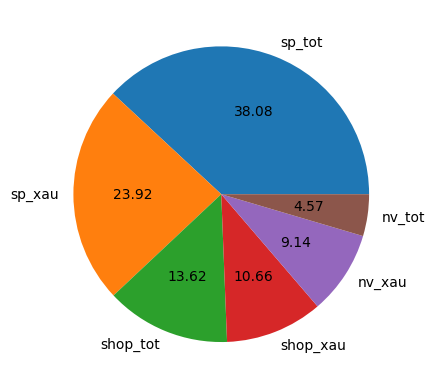

In [26]:
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%0.2f')

In [27]:
df['num_character'] = df['Review'].apply(len)
df['num_of_word'] = df['Review'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['Review'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [28]:
df

,Sentiment,Review,label,num_character,num_of_word,num_sentences
0,sp_tot,chất lượng sản phẩm : tốt đúng với mô tả : đún...,4,77,20,1
1,sp_tot,hương vị : ok bao bì / mẫu mã : bánh tráng phơ...,4,191,47,1
2,sp_tot,đúng mô tả . thanh lịch trẻ trung giá hợp lý ....,4,77,18,3
3,sp_xau,e xay đá mà bị gãy không xay được ạ,5,35,10,1
4,sp_xau,""" shop à bán hàng thì có tâm một chút . hàng c...",5,139,35,3
...,...,...,...,...,...,...
1111,shop_tot,"rất thích bộ nồi inox của shop , nhìn sang trọ...",2,71,16,1
1112,nv_xau,nhân viên không biết cách giải quyết vấn đề về...,1,57,13,1
1113,nv_xau,"nhân viên nói chuyện khó nghe , giọng nói nhỏ ...",1,102,23,2
1114,sp_xau,""" dây đồng hồ bong tróc sơn hết """,5,33,9,1


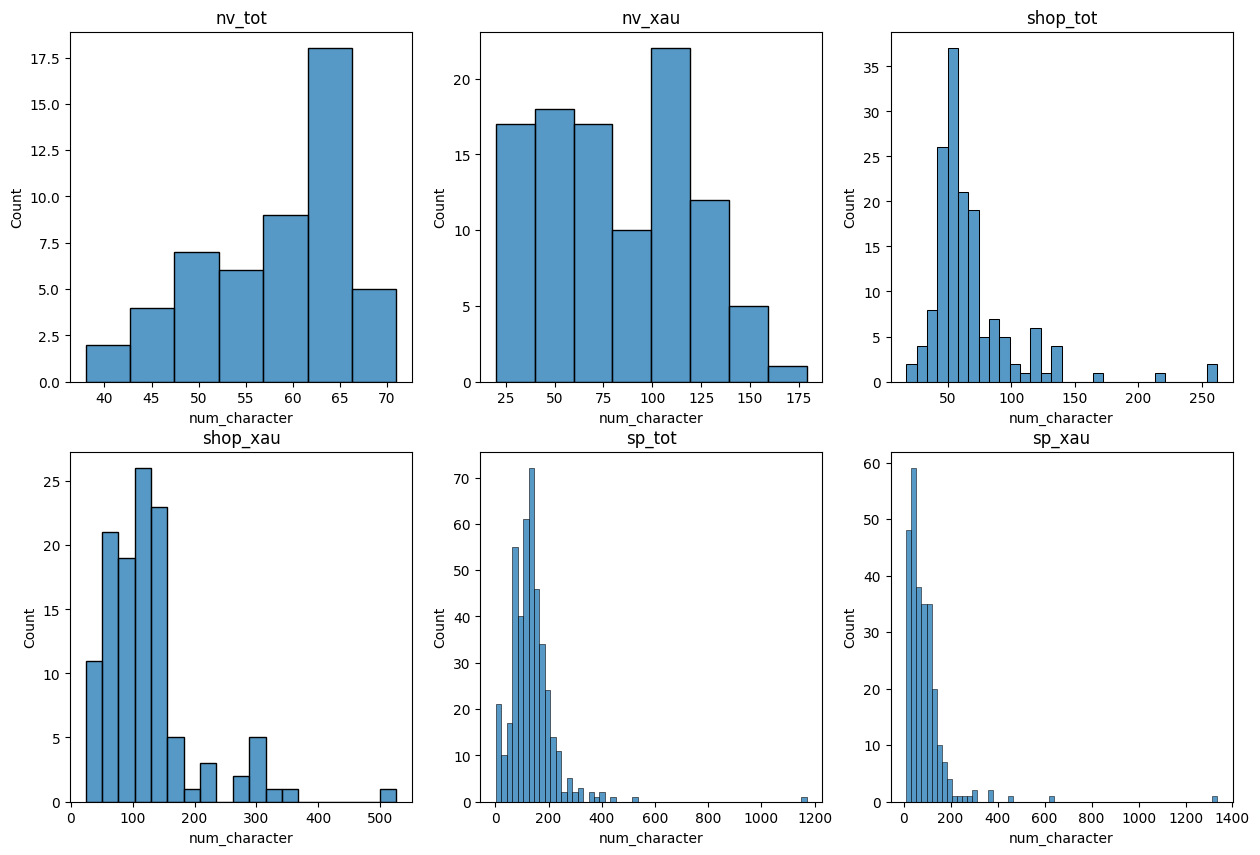

In [29]:
plt.figure(figsize=(15, 10))
for i in range(len(CLASS_NAMES)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df[df['Sentiment']==CLASS_NAMES[i]], x="num_character")
    plt.title(CLASS_NAMES[i])

<Figure size 1500x500 with 0 Axes>

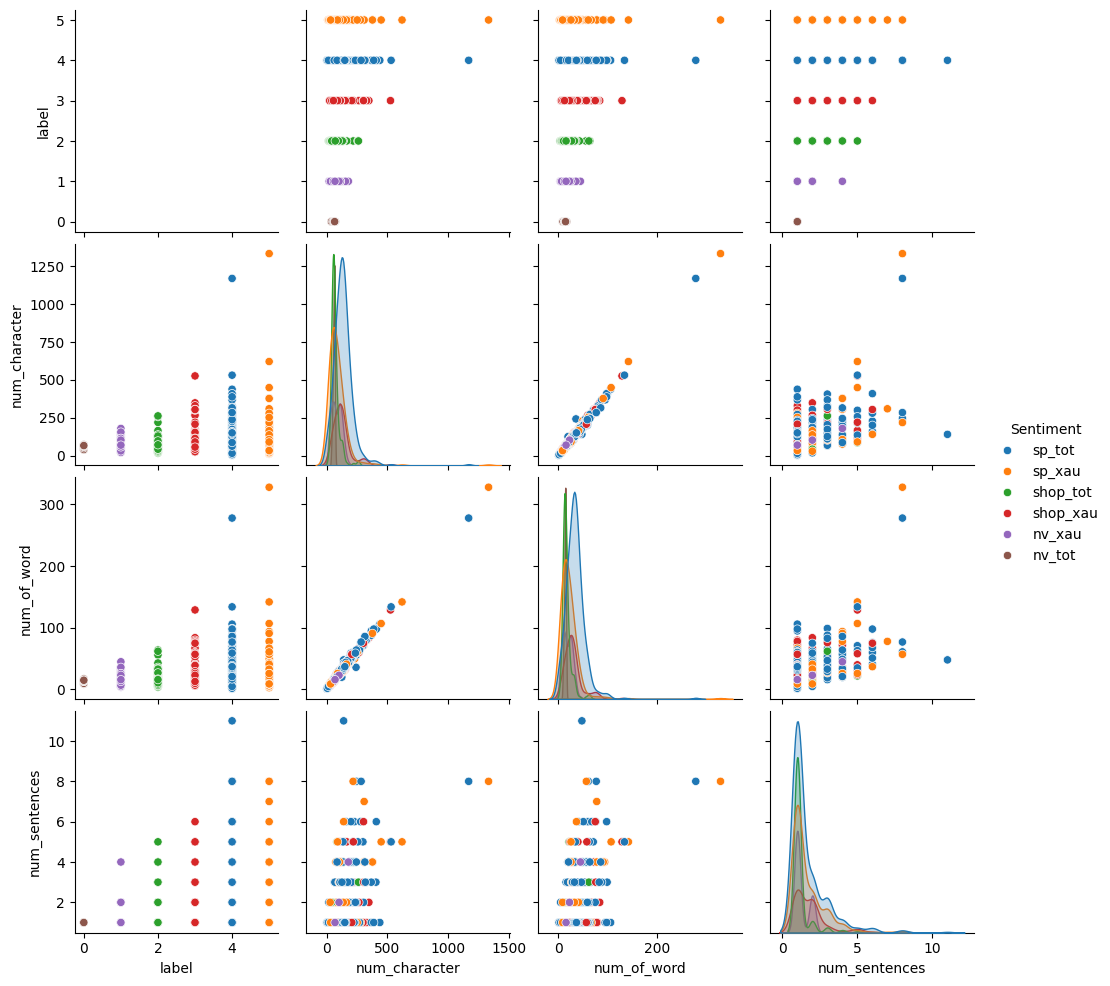

In [30]:
plt.figure(figsize=[15,5])
sns.pairplot(df, hue='Sentiment')

# Load Embedding Model

In [31]:
def load_transformer_model():
    print(os.path.isdir("model"))
    if not os.path.isdir("model"):
        model = SentenceTransformer('keepitreal/vietnamese-sbert')
        model.save("model")
        return model
    return SentenceTransformer('model')

In [32]:
vocab = []
for text in df['Review'].to_list():
    vocab.extend(text.split(" "))
vocab = list(set(vocab))
len(vocab)

2256

In [33]:
embedding_model = load_transformer_model()

True


## Embedding Text

In [34]:
features = embedding_model.encode(df['Review'], show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 35/35 [01:58<00:00,  3.40s/it]


# Create dataset 

In [35]:
x_train, x_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=0)

### Covert int to one hot

In [36]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=6)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=6)

### Reshape from (1237, 768) -> (1272, 768, 1)

In [37]:
x_train = tf.reshape(x_train, (*x_train.shape, 1))
x_test = tf.reshape(x_test, (*x_test.shape, 1))

#### Covert numpy to tf dataset from optimization training process

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_onehot)).batch(8).cache().shuffle(buffer_size=len(x_train)//8)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_onehot)).batch(8).cache().shuffle(buffer_size=len(x_test)//8)

### Splitting train ds to train and val

In [39]:
val_size = int(len(train_ds)*0.2)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Build model

In [40]:
_input = keras.layers.Input(shape=(768, 1), name="input")
x = keras.layers.LSTM(128, name='lstm')(_input)
x = keras.layers.Dropout(0.5, name="dropout")(x)
x = keras.layers.Dense(64, activation='relu', name="fc_1")(x)
x = keras.layers.Dense(6, activation='softmax', name="output")(x)
model = keras.Model(inputs=[_input], outputs=[x], name="sentiments_model")

In [41]:
model.summary()

Model: "sentiments_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 768, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,206 (293.77 KB)

 Trainable params: 75,206 (293.77 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-4),
    metrics = ['accuracy']
)

In [43]:
model.load_weights(f"./{model.name}.h5")

### Training 

In [44]:
EPOCHS = 100

In [45]:
hist = model.fit(train_ds, batch_size=8, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.7823 - loss: 0.7246 - val_accuracy: 0.8068 - val_loss: 0.6003
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.8663 - loss: 0.4823 - val_accuracy: 0.8636 - val_loss: 0.3748
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.8565 - loss: 0.4065 - val_accuracy: 0.9261 - val_loss: 0.2425
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.8629 - loss: 0.4203 - val_accuracy: 0.8920 - val_loss: 0.2740
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.8298 - loss: 0.4992 - val_accuracy: 0.8864 - val_loss: 0.2815
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.9099 - loss: 0.3132 - val_accuracy: 0.8977 - val_loss: 0.3160
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.9044 - loss: 0.2880 - val_accuracy: 0.9375 - val_loss: 0.1980
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.9159 - loss: 0.2424 - 

## Evaluate

### Loss and accuracy in training process

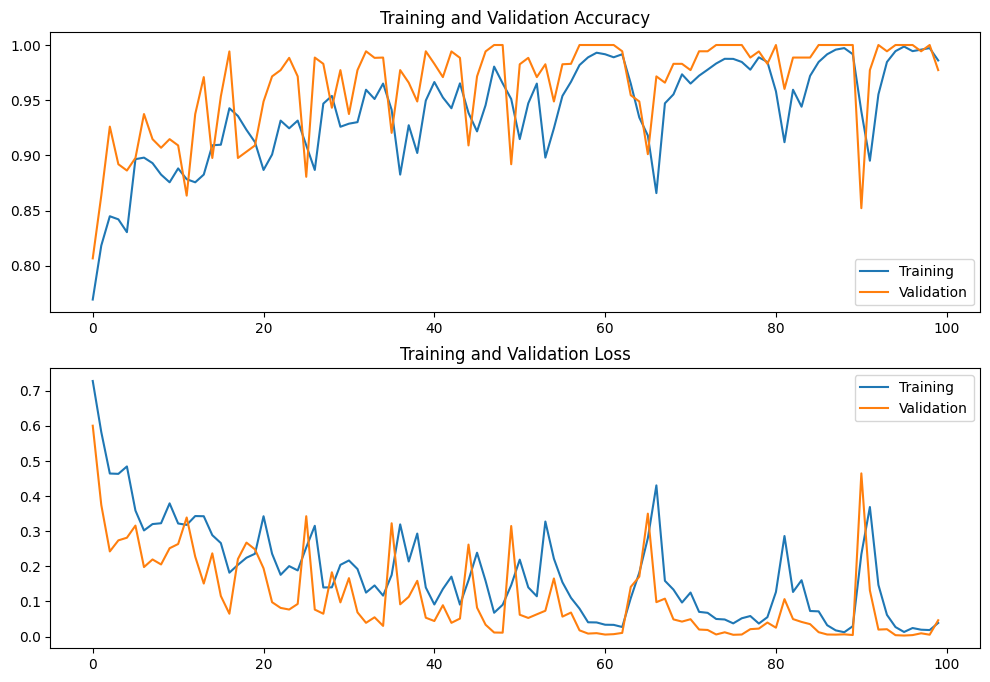

In [46]:
history = hist.history
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

labels = ['Training', 'Validation']
data_plot = [{
    'title' : 'Accuracy',
    'train_data' : train_acc,
    'val_data' : val_acc
    
}, {
    'title' : 'Loss',
    'train_data' : train_loss,
    'val_data' : val_loss
    
}
]
plt.figure(figsize=(12, 8))
for i in range(len(data_plot)):
    plt.subplot(2, 1, i+1)
    plt.plot(range(EPOCHS), data_plot[i]['train_data'], label=labels[0])
    plt.plot(range(EPOCHS), data_plot[i]['val_data'], label=labels[1])
    plt.title(f'Training and Validation {data_plot[i]["title"]}')
    plt.legend( loc='lower right' if i == 0 else 'upper right')

### Accuracy and top 5 accuracy

In [47]:
def calculate_accuracy_and_top5(model, dataset):
    
    accuracy_metric = keras.metrics.CategoricalAccuracy()
    top5_accuracy_metric = keras.metrics.TopKCategoricalAccuracy(k=5)

    for feature, labels in dataset:
        predictions = model(feature, training=False)
        accuracy_metric.update_state(labels, predictions)
        top5_accuracy_metric.update_state(labels, predictions)

    accuracy = accuracy_metric.result().numpy()
    top5_accuracy = top5_accuracy_metric.result().numpy()

    return accuracy, top5_accuracy

accuracy, top5_acc = calculate_accuracy_and_top5(model, test_ds)
    
print(f"Accuracy: {accuracy}")
print(f"Top-5 Accuracy: {top5_acc}")

Accuracy: 0.7053571343421936
Top-5 Accuracy: 0.9866071343421936


### ROC

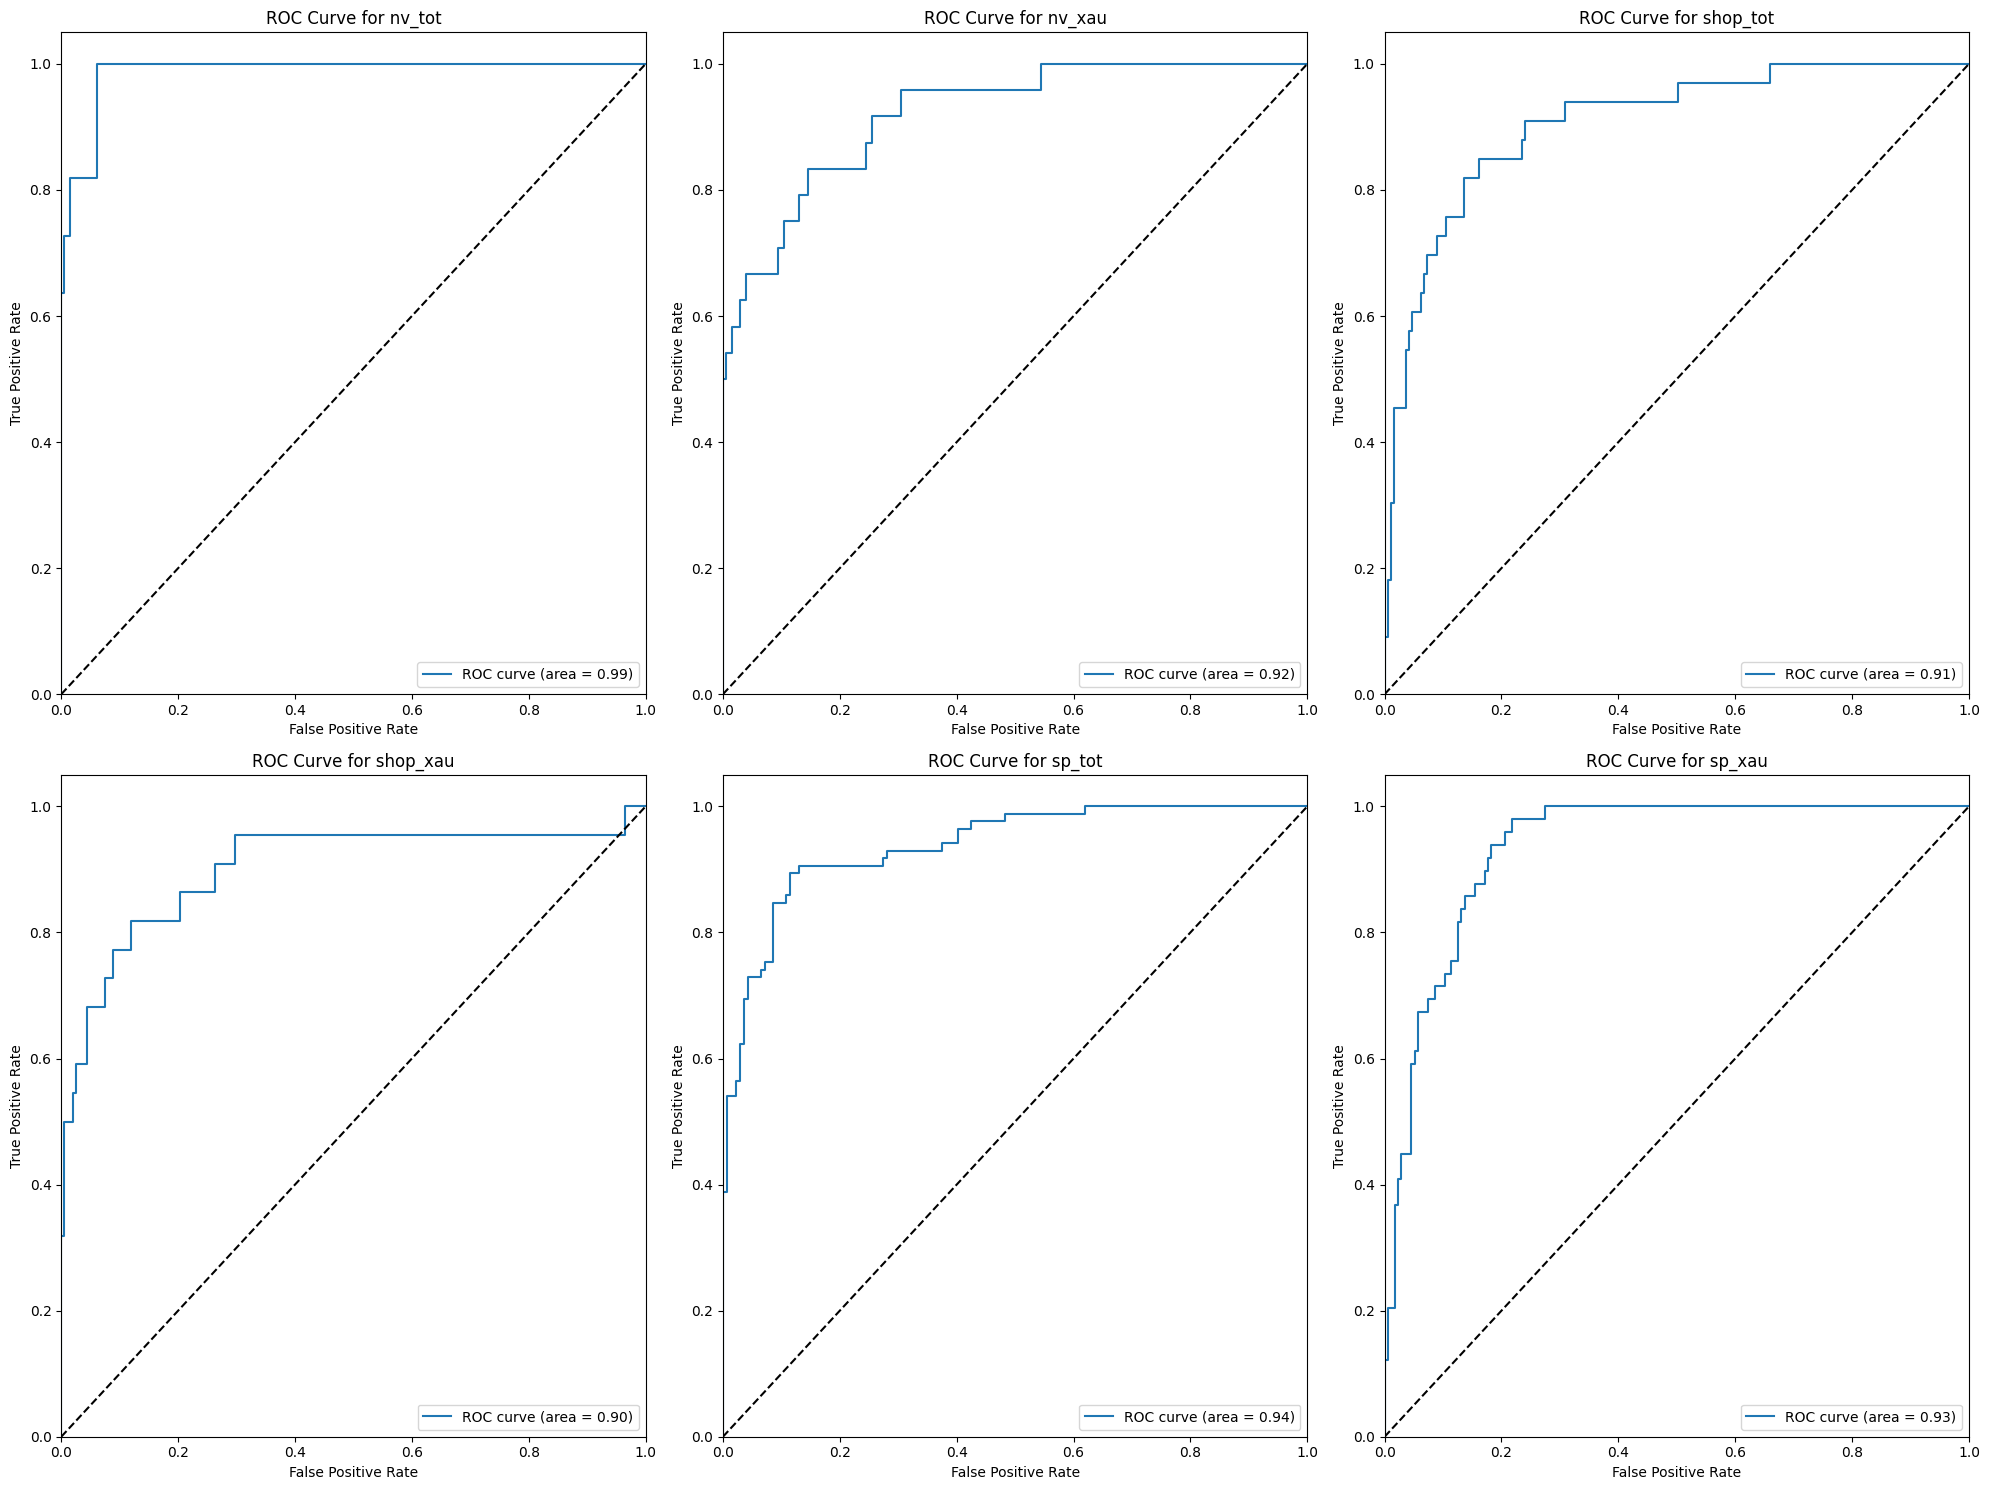

In [48]:
def plot_multiclass_roc(model, test_dataset, n_classes):
    
    y_true = []
    y_pred = []
    
    for feature, labels in test_dataset:
        y_true.append(labels.numpy())
        y_pred.append(model.predict(feature, verbose=False))
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    
    if y_true.ndim == 1 or y_true.shape[1] != n_classes:
        y_true = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    axes = axes.ravel()

    for i in range(n_classes):
        axes[i].plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'ROC Curve for {CLASS_NAMES[i]}')
        axes[i].legend(loc="lower right")
    
    # Hide any unused subplots if n_classes < 6
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
plot_multiclass_roc(model, test_ds, len(CLASS_NAMES))

### Confusion Matrix

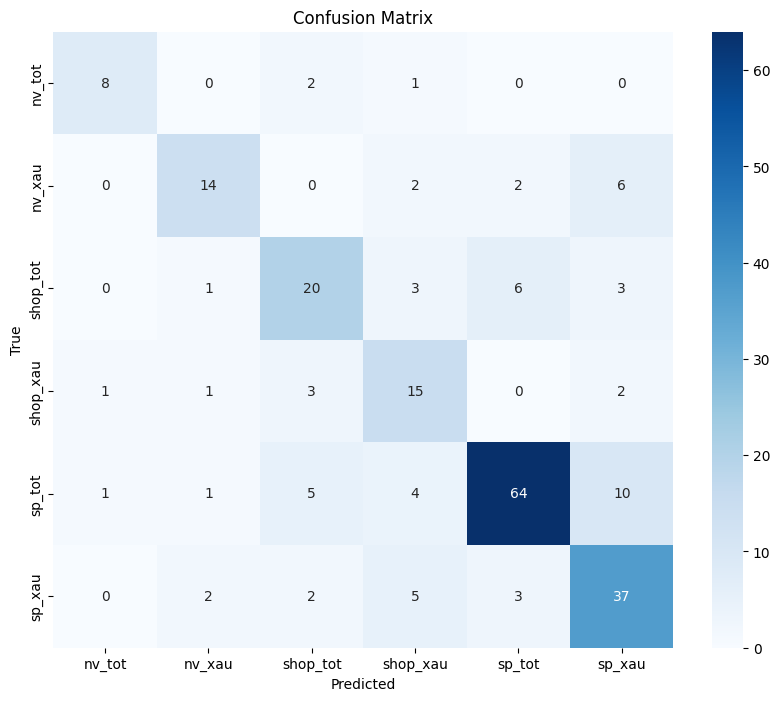

In [49]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
def visualize_confusion_matrix(model, dataset, class_names):
    
    true_labels = []
    predictions = []
    
    for features, labels in dataset:
        preds = model.predict(features, verbose=False)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))
    
    if len(true_labels) > 0 and len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)
    
    cm = confusion_matrix(true_labels, predictions)
    
    plot_confusion_matrix(cm, class_names)
    
    
visualize_confusion_matrix(model, test_ds, CLASS_NAMES)

In [50]:
model.evaluate(train_ds)

90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9798 - loss: 0.0467


[0.03295973315834999, 0.9861111044883728]

In [51]:
model.save(f"{model.name}.h5")
model.export(f"{model.name}")

INFO:tensorflow:Assets written to: sentiments_model\assets


INFO:tensorflow:Assets written to: sentiments_model\assets


Saved artifact at 'sentiments_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 768, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2132459996752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132460009040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132459997136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132459996560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132459996944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132460008464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2132475052304: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [52]:
def cls_comment(cmt):
    feature = embedding_model.encode(cmt)
    feature = feature[:, np.newaxis]
    
    pred = model.predict(tf.expand_dims(feature, axis=0))
    cls = pred.argmax(axis=1)
    print(CLASS_NAMES[int(cls)])
cls_comment("Shop này làm ăn quá tệ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
sp_xau


C:\Users\Chung Vu\AppData\Local\Temp\ipykernel_6296\3968641850.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(CLASS_NAMES[int(cls)])
